Head of data:
  battery_id  cycle       chI       chV        chT      disI      disV  \
0         B5      1  1.440147  4.254682  23.988733  1.894407  3.273523   
1         B5      2  1.416595  4.159825  25.665347  1.829949  4.038741   
2         B5      3  1.420272  4.276323  25.407910  1.942105  3.214433   
3         B5      4  1.337680  4.236697  27.069757  2.073577  3.134529   
4         B5      5  1.263946  4.142791  26.478353  2.049885  3.729341   

        disT       BCt        SOH  RUL  
0  32.980834  1.986196  99.309790  219  
1  32.257920  1.986240  99.311985  218  
2  35.134801  1.984252  99.212608  217  
3  32.082988  1.969236  98.461812  216  
4  32.483154  1.974862  98.743106  215  

Columns: ['battery_id', 'cycle', 'chI', 'chV', 'chT', 'disI', 'disV', 'disT', 'BCt', 'SOH', 'RUL']

Train size: 476, Test size: 204
Train batteries: ['B5' 'B6' 'B7']
Test batteries: ['B5' 'B6' 'B7']

================ Gradient Boosting Models ================

=== GB SOH - Train ===
RMSE : 0.01

/Users/uditbhardwaj/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6526.3052 - mse: 6526.3052 - val_loss: 4347.9668 - val_mse: 4347.9668
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6332.5464 - mse: 6332.5464 - val_loss: 4053.2954 - val_mse: 4053.2954
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6112.1128 - mse: 6112.1128 - val_loss: 3389.6802 - val_mse: 3389.6804
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5513.0635 - mse: 5513.0635 - val_loss: 2713.6528 - val_mse: 2713.6528
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4124.8691 - mse: 4124.8691 - val_loss: 2008.2100 - val_mse: 2008.2100
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3222.2495 - mse: 3222.2495 - val_loss: 1409.6600 - val_mse: 1409.6600
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2463.0847 - mse: 2463.0847 - val_loss: 926.5405 - val_mse: 926.5405
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1891.0275 - mse: 1891.0275 - val_loss: 556.7512 - v

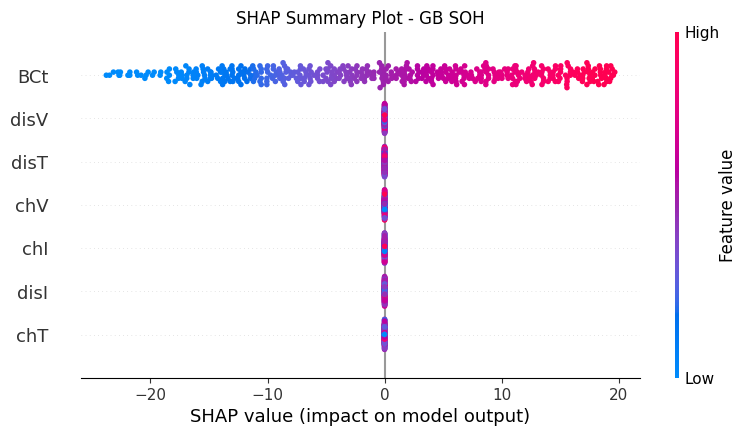

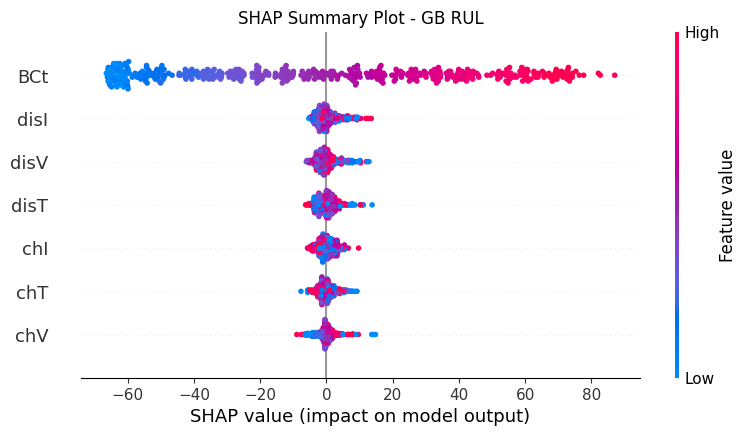


================ LIME (Gradient Boosting) ================
Explaining GB SOH prediction for test instance index 102



LIME explanation (GB SOH):
[('BCt <= 1.40', -20.4429087063751), ('chI > 1.46', 0.5535226432032863), ('chV <= 4.17', -0.2696885523306157), ('1.95 < disI <= 2.00', 0.18812667684451848), ('disT <= 31.93', -0.1575482060156602), ('disV <= 3.31', 0.07783721325600682), ('25.76 < chT <= 26.68', 0.013416458678861662)]


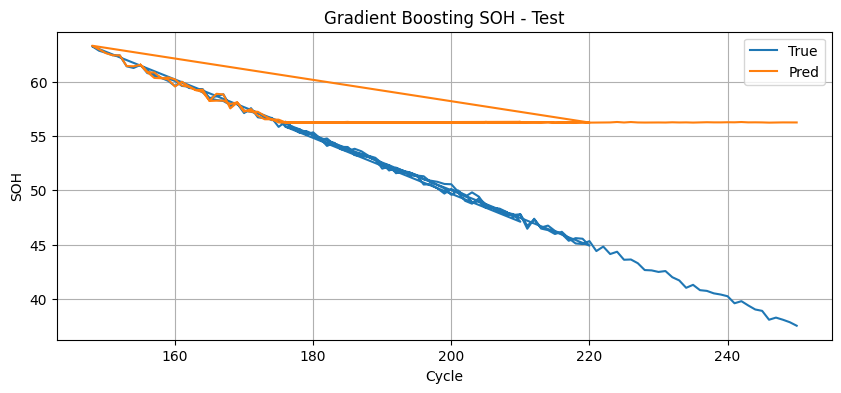

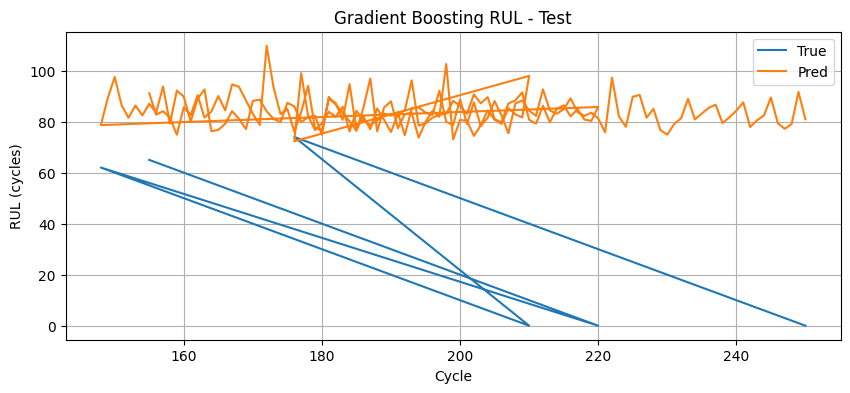

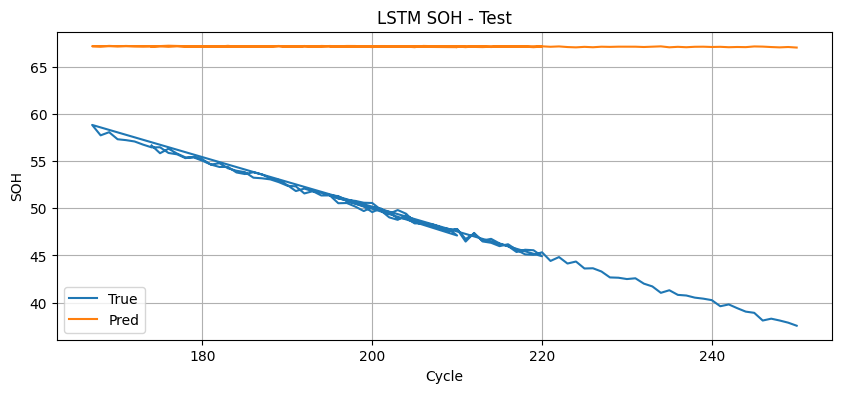

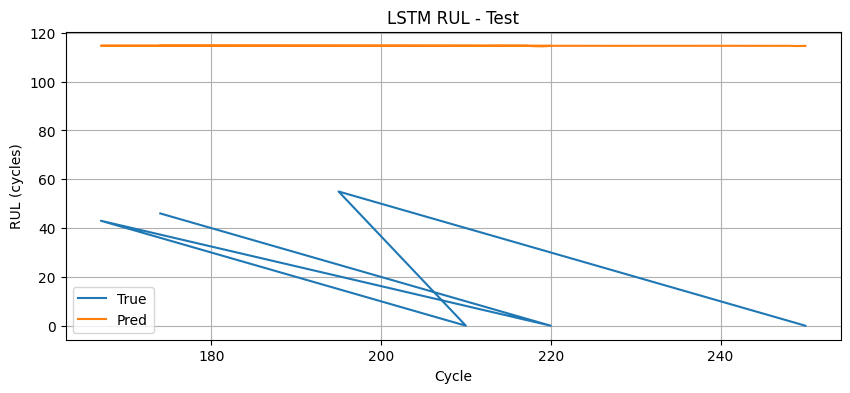


All training, evaluation, and explainability steps completed.


In [ ]:


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import shap
from lime import lime_tabular

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------------------------------------------
# 1. Load dataset
# ------------------------------------------------------------

CSV_PATH = "Battery_dataset 2.csv"  # make sure this file is uploaded in Colab
df = pd.read_csv(CSV_PATH)

print("Head of data:")
print(df.head())
print("\nColumns:", df.columns.tolist())

# Expected columns:
# ['battery_id', 'cycle', 'chI', 'chV', 'chT',
#  'disI', 'disV', 'disT', 'BCt', 'SOH', 'RUL']

# ------------------------------------------------------------
# 2. Basic preprocessing & train-test split (per battery)
# ------------------------------------------------------------

# Sort by battery and cycle to keep time order
df = df.sort_values(["battery_id", "cycle"]).reset_index(drop=True)

# Feature and target columns
feature_cols = ["chI", "chV", "chT", "disI", "disV", "disT", "BCt"]
target_soh = "SOH"
target_rul = "RUL"

# Train/test split per battery (e.g. 70% cycles train, 30% test)
train_fraction = 0.7

train_indices = []
test_indices = []

for bid, grp in df.groupby("battery_id"):
    n = len(grp)
    n_train_b = int(n * train_fraction)
    idx = grp.index.to_list()
    train_indices.extend(idx[:n_train_b])
    test_indices.extend(idx[n_train_b:])

df_train = df.loc[train_indices].sort_values(["battery_id", "cycle"]).reset_index(drop=True)
df_test  = df.loc[test_indices].sort_values(["battery_id", "cycle"]).reset_index(drop=True)

print(f"\nTrain size: {len(df_train)}, Test size: {len(df_test)}")
print("Train batteries:", df_train["battery_id"].unique())
print("Test batteries:", df_test["battery_id"].unique())

# Data for Gradient Boosting (no scaling required, but it's fine unscaled)
X_train_gb = df_train[feature_cols].values
X_test_gb  = df_test[feature_cols].values

y_train_soh = df_train[target_soh].values
y_test_soh  = df_test[target_soh].values

y_train_rul = df_train[target_rul].values
y_test_rul  = df_test[target_rul].values

# ------------------------------------------------------------
# 3. Metrics helpers (RMSE, MAE, MAPE, R²)
# ------------------------------------------------------------

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / (y_true + eps))) * 100.0

def metrics_report(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(f"RMSE : {rmse(y_true, y_pred):.6f}")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"MAPE : {mape(y_true, y_pred):.4f}%")
    print(f"R²   : {r2_score(y_true, y_pred):.6f}")

# ------------------------------------------------------------
# 4. Gradient Boosting models for SOH & RUL
# ------------------------------------------------------------

print("\n================ Gradient Boosting Models ================")

gb_soh = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    random_state=42
)

gb_rul = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    random_state=42
)

# Train
gb_soh.fit(X_train_gb, y_train_soh)
gb_rul.fit(X_train_gb, y_train_rul)

# Predict
gb_soh_pred_train = gb_soh.predict(X_train_gb)
gb_soh_pred_test  = gb_soh.predict(X_test_gb)

gb_rul_pred_train = gb_rul.predict(X_train_gb)
gb_rul_pred_test  = gb_rul.predict(X_test_gb)

# Metrics
metrics_report("GB SOH - Train", y_train_soh, gb_soh_pred_train)
metrics_report("GB SOH - Test",  y_test_soh,  gb_soh_pred_test)

metrics_report("GB RUL - Train", y_train_rul, gb_rul_pred_train)
metrics_report("GB RUL - Test",  y_test_rul,  gb_rul_pred_test)

# ------------------------------------------------------------
# 5. LSTM models (sequence-based) for SOH & RUL
# ------------------------------------------------------------

print("\n================ LSTM Models ================")

# Scale features for LSTM
scaler = StandardScaler()
X_train_lstm = scaler.fit_transform(df_train[feature_cols].values)
X_test_lstm  = scaler.transform(df_test[feature_cols].values)

battery_train = df_train["battery_id"].values
battery_test  = df_test["battery_id"].values

def create_sequences(X, y, battery_ids, seq_len):
    """
    Create sliding windows of length seq_len, but do NOT cross battery boundaries.
    """
    X_seq, y_seq = [], []
    N = len(X)
    for i in range(N - seq_len + 1):
        # ensure all seq_len points belong to same battery
        if len(set(battery_ids[i:i+seq_len])) == 1:
            X_seq.append(X[i:i+seq_len])
            y_seq.append(y[i+seq_len-1])  # predict last point in the sequence
    return np.array(X_seq), np.array(y_seq)

seq_len = 20  # can tune

# SOH sequences
X_train_seq_soh, y_train_seq_soh = create_sequences(
    X_train_lstm, y_train_soh, battery_train, seq_len
)
X_test_seq_soh, y_test_seq_soh = create_sequences(
    X_test_lstm, y_test_soh, battery_test, seq_len
)

# RUL sequences
X_train_seq_rul, y_train_seq_rul = create_sequences(
    X_train_lstm, y_train_rul, battery_train, seq_len
)
X_test_seq_rul, y_test_seq_rul = create_sequences(
    X_test_lstm, y_test_rul, battery_test, seq_len
)

print("LSTM sequence shapes (SOH):", X_train_seq_soh.shape, X_test_seq_soh.shape)
print("LSTM sequence shapes (RUL):", X_train_seq_rul.shape, X_test_seq_rul.shape)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))
    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["mse"]
    )
    return model

lstm_soh = build_lstm_model(X_train_seq_soh.shape[1:])
lstm_rul = build_lstm_model(X_train_seq_rul.shape[1:])

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Train LSTM SOH
history_soh = lstm_soh.fit(
    X_train_seq_soh, y_train_seq_soh,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Train LSTM RUL
history_rul = lstm_rul.fit(
    X_train_seq_rul, y_train_seq_rul,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict
lstm_soh_pred_train = lstm_soh.predict(X_train_seq_soh).flatten()
lstm_soh_pred_test  = lstm_soh.predict(X_test_seq_soh).flatten()

lstm_rul_pred_train = lstm_rul.predict(X_train_seq_rul).flatten()
lstm_rul_pred_test  = lstm_rul.predict(X_test_seq_rul).flatten()

# Metrics
metrics_report("LSTM SOH - Train", y_train_seq_soh, lstm_soh_pred_train)
metrics_report("LSTM SOH - Test",  y_test_seq_soh,  lstm_soh_pred_test)

metrics_report("LSTM RUL - Train", y_train_seq_rul, lstm_rul_pred_train)
metrics_report("LSTM RUL - Test",  y_test_seq_rul,  lstm_rul_pred_test)

# ------------------------------------------------------------
# 6. Explainability: SHAP for Gradient Boosting
# ------------------------------------------------------------

print("\n================ SHAP (Gradient Boosting) ================")

# SHAP for tree-based models
explainer_soh = shap.TreeExplainer(gb_soh)
shap_values_soh = explainer_soh.shap_values(X_train_gb)

# Summary plot for SOH model
shap.summary_plot(shap_values_soh, X_train_gb, feature_names=feature_cols, show=False)
plt.title("SHAP Summary Plot - GB SOH")
plt.show()

# Optional: SHAP for RUL model
explainer_rul = shap.TreeExplainer(gb_rul)
shap_values_rul = explainer_rul.shap_values(X_train_gb)

shap.summary_plot(shap_values_rul, X_train_gb, feature_names=feature_cols, show=False)
plt.title("SHAP Summary Plot - GB RUL")
plt.show()

# ------------------------------------------------------------
# 7. Explainability: LIME for Gradient Boosting
# ------------------------------------------------------------

print("\n================ LIME (Gradient Boosting) ================")

explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_gb,
    feature_names=feature_cols,
    mode="regression"
)

if len(X_test_gb) > 0:
    idx = len(X_test_gb) // 2  # explain middle test sample
    instance = X_test_gb[idx]

    print(f"Explaining GB SOH prediction for test instance index {idx}")
    exp_soh = explainer_lime.explain_instance(
        data_row=instance,
        predict_fn=gb_soh.predict,
        num_features=min(10, len(feature_cols))
    )
    # In notebook, this shows a nice HTML explanation
    exp_soh.show_in_notebook(show_all=False)

    print("\nLIME explanation (GB SOH):")
    print(exp_soh.as_list())

# ------------------------------------------------------------
# 8. (Optional) SHAP for LSTM using KernelExplainer (very slow)
# ------------------------------------------------------------
"""
print("\\n================ Optional SHAP (LSTM SOH) ================")

# Flatten sequences for KernelExplainer
n_timesteps = X_train_seq_soh.shape[1]
n_feats = X_train_seq_soh.shape[2]

X_train_flat = X_train_seq_soh.reshape(len(X_train_seq_soh), n_timesteps * n_feats)

# Take a small subset for SHAP
n_background = min(50, len(X_train_flat))
background = X_train_flat[:n_background]

def lstm_soh_predict_flat(x_flat):
    x_seq = x_flat.reshape(-1, n_timesteps, n_feats)
    return lstm_soh.predict(x_seq).flatten()

kernel_explainer = shap.KernelExplainer(lstm_soh_predict_flat, background)
X_sample_flat = X_train_flat[:30]  # explain first 30
shap_values_lstm = kernel_explainer.shap_values(X_sample_flat, nsamples=100)

shap.summary_plot(shap_values_lstm, X_sample_flat, show=False)
plt.title("SHAP (Kernel) - LSTM SOH (flattened features)")
plt.show()
"""

# ------------------------------------------------------------
# 9. Plots: True vs Predicted on Test Set
# ------------------------------------------------------------

def plot_true_pred(cycles, y_true, y_pred, title, ylabel):
    plt.figure(figsize=(10, 4))
    plt.plot(cycles, y_true, label="True")
    plt.plot(cycles, y_pred, label="Pred")
    plt.xlabel("Cycle")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# For GB, cycles directly from df_test
cycles_test = df_test["cycle"].values

plot_true_pred(
    cycles_test, y_test_soh, gb_soh_pred_test,
    "Gradient Boosting SOH - Test", "SOH"
)

plot_true_pred(
    cycles_test, y_test_rul, gb_rul_pred_test,
    "Gradient Boosting RUL - Test", "RUL (cycles)"
)

# For LSTM, sequences predict last point in each window.
# Map sequence predictions to matching cycles.
# We'll reconstruct cycles for sequences similarly to how we built sequences:
def sequence_cycles(df_subset, seq_len):
    # we must respect battery boundaries
    df_sub = df_subset.sort_values(["battery_id", "cycle"]).reset_index(drop=True)
    cycles = df_sub["cycle"].values
    battery_ids = df_sub["battery_id"].values
    seq_cycles = []
    N = len(df_sub)
    for i in range(N - seq_len + 1):
        if len(set(battery_ids[i:i+seq_len])) == 1:
            seq_cycles.append(cycles[i+seq_len-1])
    return np.array(seq_cycles)

cycles_test_seq = sequence_cycles(df_test, seq_len)

plot_true_pred(
    cycles_test_seq, y_test_seq_soh, lstm_soh_pred_test,
    "LSTM SOH - Test", "SOH"
)

plot_true_pred(
    cycles_test_seq, y_test_seq_rul, lstm_rul_pred_test,
    "LSTM RUL - Test", "RUL (cycles)"
)

print("\nAll training, evaluation, and explainability steps completed.")


In [6]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ============================================================
# 1. Load dataset
# ============================================================

CSV_PATH = "Battery_dataset 2.csv"  # put this file in the same folder
df = pd.read_csv(CSV_PATH)

print("Data head:")
print(df.head())
print("\nColumns:", df.columns.tolist())

# Expected columns:
# ['battery_id', 'cycle', 'chI', 'chV', 'chT',
#  'disI', 'disV', 'disT', 'BCt', 'SOH', 'RUL']

# Sort by battery and cycle (time order is important)
df = df.sort_values(["battery_id", "cycle"]).reset_index(drop=True)

# ============================================================
# 2. Train / Test split per battery
# ============================================================

feature_cols = ["chI", "chV", "chT", "disI", "disV", "disT", "BCt"]
target_soh = "SOH"
target_rul = "RUL"

train_fraction = 0.7

train_idx = []
test_idx = []

for bid, grp in df.groupby("battery_id"):
    n = len(grp)
    n_train = int(n * train_fraction)
    idx = grp.index.to_list()
    train_idx += idx[:n_train]
    test_idx += idx[n_train:]

df_train = df.loc[train_idx].sort_values(["battery_id", "cycle"]).reset_index(drop=True)
df_test  = df.loc[test_idx].sort_values(["battery_id", "cycle"]).reset_index(drop=True)

print(f"\nTrain size: {len(df_train)}, Test size: {len(df_test)}")
print("Train batteries:", df_train["battery_id"].unique())
print("Test batteries:", df_test["battery_id"].unique())

# ============================================================
# 3. Scaling features for LSTM
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train[feature_cols].values)
X_test_scaled  = scaler.transform(df_test[feature_cols].values)

y_train_soh = df_train[target_soh].values
y_test_soh  = df_test[target_soh].values

y_train_rul = df_train[target_rul].values
y_test_rul  = df_test[target_rul].values

battery_train = df_train["battery_id"].values
battery_test  = df_test["battery_id"].values

# Optional: save scaler if you want to use model later for inference
import joblib
joblib.dump(scaler, "battery_feature_scaler.pkl")
print("\nSaved scaler to battery_feature_scaler.pkl")

# ============================================================
# 4. Create sequences for LSTM (no crossing batteries)
# ============================================================

SEQ_LEN = 20  # you can tune this

def create_sequences(X, y, battery_ids, seq_len):
    X_seq, y_seq = [], []
    N = len(X)
    for i in range(N - seq_len + 1):
        # ensure all steps in window belong to same battery
        if len(set(battery_ids[i:i+seq_len])) == 1:
            X_seq.append(X[i:i+seq_len])
            y_seq.append(y[i+seq_len-1])   # predict last point
    return np.array(X_seq), np.array(y_seq)

# SOH sequences
X_train_seq_soh, y_train_seq_soh = create_sequences(
    X_train_scaled, y_train_soh, battery_train, SEQ_LEN
)
X_test_seq_soh, y_test_seq_soh = create_sequences(
    X_test_scaled, y_test_soh, battery_test, SEQ_LEN
)

# RUL sequences
X_train_seq_rul, y_train_seq_rul = create_sequences(
    X_train_scaled, y_train_rul, battery_train, SEQ_LEN
)
X_test_seq_rul, y_test_seq_rul = create_sequences(
    X_test_scaled, y_test_rul, battery_test, SEQ_LEN
)

print("\nSOH sequences shape (train, test):", X_train_seq_soh.shape, X_test_seq_soh.shape)
print("RUL sequences shape (train, test):", X_train_seq_rul.shape, X_test_seq_rul.shape)

# ============================================================
# 5. Build LSTM models
# ============================================================

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))  # regression output
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mse"]
    )
    return model

lstm_soh = build_lstm_model(X_train_seq_soh.shape[1:])
lstm_rul = build_lstm_model(X_train_seq_rul.shape[1:])

print("\n================ LSTM SOH Model Summary ================")
lstm_soh.summary()

print("\n================ LSTM RUL Model Summary ================")
lstm_rul.summary()

# ============================================================
# 6. Train models
# ============================================================

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

print("\nTraining LSTM for SOH prediction...")
history_soh = lstm_soh.fit(
    X_train_seq_soh, y_train_seq_soh,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining LSTM for RUL prediction...")
history_rul = lstm_rul.fit(
    X_train_seq_rul, y_train_seq_rul,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ============================================================
# 7. Evaluate and print basic errors
# ============================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / (y_true + eps))) * 100.0

def report_metrics(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(f"RMSE : {rmse(y_true, y_pred):.6f}")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"MAPE : {mape(y_true, y_pred):.4f}%")
    print(f"R²   : {r2_score(y_true, y_pred):.6f}")

# Predictions
y_train_pred_soh = lstm_soh.predict(X_train_seq_soh).flatten()
y_test_pred_soh  = lstm_soh.predict(X_test_seq_soh).flatten()

y_train_pred_rul = lstm_rul.predict(X_train_seq_rul).flatten()
y_test_pred_rul  = lstm_rul.predict(X_test_seq_rul).flatten()

report_metrics("LSTM SOH - Train", y_train_seq_soh, y_train_pred_soh)
report_metrics("LSTM SOH - Test",  y_test_seq_soh,  y_test_pred_soh)

report_metrics("LSTM RUL - Train", y_train_seq_rul, y_train_pred_rul)
report_metrics("LSTM RUL - Test",  y_test_seq_rul,  y_test_pred_rul)

# ============================================================
# 8. Save models as .h5
# ============================================================

SOH_MODEL_PATH = "lstm_soh_model.h5"
RUL_MODEL_PATH = "lstm_rul_model.h5"

lstm_soh.save(SOH_MODEL_PATH)
lstm_rul.save(RUL_MODEL_PATH)

print(f"\nSaved SOH model to: {os.path.abspath(SOH_MODEL_PATH)}")
print(f"Saved RUL model to: {os.path.abspath(RUL_MODEL_PATH)}")

print("\nDone ✅")


Data head:
  battery_id  cycle       chI       chV        chT      disI      disV  \
0         B5      1  1.440147  4.254682  23.988733  1.894407  3.273523   
1         B5      2  1.416595  4.159825  25.665347  1.829949  4.038741   
2         B5      3  1.420272  4.276323  25.407910  1.942105  3.214433   
3         B5      4  1.337680  4.236697  27.069757  2.073577  3.134529   
4         B5      5  1.263946  4.142791  26.478353  2.049885  3.729341   

        disT       BCt        SOH  RUL  
0  32.980834  1.986196  99.309790  219  
1  32.257920  1.986240  99.311985  218  
2  35.134801  1.984252  99.212608  217  
3  32.082988  1.969236  98.461812  216  
4  32.483154  1.974862  98.743106  215  

Columns: ['battery_id', 'cycle', 'chI', 'chV', 'chT', 'disI', 'disV', 'disT', 'BCt', 'SOH', 'RUL']

Train size: 476, Test size: 204
Train batteries: ['B5' 'B6' 'B7']
Test batteries: ['B5' 'B6' 'B7']

Saved scaler to battery_feature_scaler.pkl

SOH sequences shape (train, test): (419, 20, 7) (147,

/Users/uditbhardwaj/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)


================ LSTM RUL Model Summary ================


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM for SOH prediction...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6492.3091 - mse: 6492.3091 - val_loss: 4476.4907 - val_mse: 4476.4907
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6289.3726 - mse: 6289.3726 - val_loss: 4462.5288 - val_mse: 4462.5288
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5716.7480 - mse: 5716.7480 - val_loss: 3949.1875 - val_mse: 3949.1875
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4846.4360 - mse: 4846.4360 - val_loss: 2795.6294 - val_mse: 2795.6294
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3777.1855 - mse: 3777.1855 - val_loss: 1776.5483 - val_mse: 1776.5483
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2995.9880 - mse: 2995.9880 - val_loss: 1268.1715 - val_mse: 1268.1715
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2243.1929 - mse: 2243.1929 - val_loss: 860.4606 - val_mse: 860.4606
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18


=== LSTM SOH - Train ===
RMSE : 15.636584
MAE  : 12.915932
MAPE : 15.5172%
R²   : -1.306959

=== LSTM SOH - Test ===
RMSE : 17.331211
MAE  : 16.499943
MAPE : 35.2514%
R²   : -10.268418

=== LSTM RUL - Train ===
RMSE : 48.610204
MAE  : 39.840496
MAPE : 27.9090%
R²   : -0.321517

=== LSTM RUL - Test ===
RMSE : 82.405020
MAE  : 77.503754
MAPE : 94007565.8224%
R²   : -30.820070



Saved SOH model to: /Users/uditbhardwaj/Documents/AndroidProjects/Lithium-ion-batteryNASA/lstm_soh_model.h5
Saved RUL model to: /Users/uditbhardwaj/Documents/AndroidProjects/Lithium-ion-batteryNASA/lstm_rul_model.h5

Done ✅


In [8]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# ============================================================
# Load Models + Scaler
# ============================================================

scaler = joblib.load("battery_feature_scaler.pkl")

# NOTE: compile=False avoids the 'mse' deserialization error
lstm_soh = load_model("lstm_soh_model.h5", compile=False)
lstm_rul = load_model("lstm_rul_model.h5", compile=False)

print("Models loaded successfully!")

# ============================================================
# 1. Load dataset to prepare test sequence
# ============================================================

df = pd.read_csv("Battery_dataset 2.csv")
df = df.sort_values(["battery_id", "cycle"]).reset_index(drop=True)

feature_cols = ["chI", "chV", "chT", "disI", "disV", "disT", "BCt"]

# ============================================================
# 2. Function: generate last 20-cycle window for a battery
# ============================================================

def get_last_20_cycles(df, battery_id):
    sub = df[df["battery_id"] == battery_id].tail(20)
    if len(sub) < 20:
        raise ValueError("Not enough cycles available (need 20 cycles)")
    X = scaler.transform(sub[feature_cols].values)
    return X.reshape(1, 20, len(feature_cols))   # shape (1,20,7)

# ============================================================
# 3. TEST: Predict for battery B5 (for example)
# ============================================================

battery_to_test = "B5"

X_seq = get_last_20_cycles(df, battery_to_test)

soh_pred = lstm_soh.predict(X_seq)[0, 0]
rul_pred = lstm_rul.predict(X_seq)[0, 0]

print("\n==================== Results ====================")
print(f"Battery ID: {battery_to_test}")
print(f"Predicted SOH: {soh_pred:.4f}")
print(f"Predicted RUL: {rul_pred:.2f} cycles")
print("=================================================\n")


Models loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

==================== Results ====================
Battery ID: B5
Predicted SOH: 42.4239
Predicted RUL: 10.86 cycles



In [9]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# ============================================================
# Load Models + Scaler
# ============================================================

scaler = joblib.load("battery_feature_scaler.pkl")
lstm_soh = load_model("lstm_soh_model.h5", compile=False)
lstm_rul = load_model("lstm_rul_model.h5", compile=False)

print("Models loaded successfully!")

# ============================================================
# Your Custom Input
# ============================================================

input_json = {
    "cycle": 154,
    "voltage": 3.7,
    "current": 1.0,
    "temperature": 30.0,
    "capacity": 2800,
    "window_data": [
        2950, 2920, 2890, 2860, 2830, 2800, 2770, 2740, 2710, 2680,
        2650, 2620, 2590, 2560, 2530, 2500, 2470, 2440, 2410, 2380
    ]
}

# ============================================================
# Convert input → LSTM sequence of shape (1,20,7)
# ============================================================

window_data = input_json["window_data"]  # 20 capacity values
if len(window_data) != 20:
    raise ValueError("window_data must contain exactly 20 values!")

seq = []
for bc in window_data:
    row = [
        input_json["current"],      # chI
        input_json["voltage"],      # chV
        input_json["temperature"],  # chT
        input_json["current"],      # disI (assumed same)
        input_json["voltage"],      # disV (assumed same)
        input_json["temperature"],  # disT (assumed same)
        bc                           # BCt = capacity value from window_data
    ]
    seq.append(row)

seq = np.array(seq)  # (20,7)

# Scale using training scaler
seq_scaled = scaler.transform(seq)

# Reshape for LSTM: (1,20,7)
X_input = seq_scaled.reshape(1, 20, 7)

# ============================================================
# Predict
# ============================================================

soh_pred = lstm_soh.predict(X_input)[0, 0]
rul_pred = lstm_rul.predict(X_input)[0, 0]

print("\n==================== Prediction ====================")
print(f"Predicted SOH : {soh_pred:.4f}")
print(f"Predicted RUL : {rul_pred:.2f} cycles")
print("====================================================")


Models loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

==================== Prediction ====================
Predicted SOH : 13.7960
Predicted RUL : 23.04 cycles


# multi-output model:


In [10]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ============================================================
# 1. Load dataset
# ============================================================

CSV_PATH = "Battery_dataset 2.csv"  # adjust path if needed
df = pd.read_csv(CSV_PATH)

print("Data head:")
print(df.head())
print("\nColumns:", df.columns.tolist())

# Expected columns:
# ['battery_id', 'cycle', 'chI', 'chV', 'chT',
#  'disI', 'disV', 'disT', 'BCt', 'SOH', 'RUL']

# Sort by battery and cycle
df = df.sort_values(["battery_id", "cycle"]).reset_index(drop=True)

# ============================================================
# 2. Train / Test split per battery
# ============================================================

feature_cols = ["chI", "chV", "chT", "disI", "disV", "disT", "BCt"]
target_cols = ["SOH", "RUL"]   # two outputs

train_fraction = 0.7

train_idx = []
test_idx = []

for bid, grp in df.groupby("battery_id"):
    n = len(grp)
    n_train = int(n * train_fraction)
    idx = grp.index.to_list()
    train_idx += idx[:n_train]
    test_idx += idx[n_train:]

df_train = df.loc[train_idx].sort_values(["battery_id", "cycle"]).reset_index(drop=True)
df_test  = df.loc[test_idx].sort_values(["battery_id", "cycle"]).reset_index(drop=True)

print(f"\nTrain size: {len(df_train)}, Test size: {len(df_test)}")
print("Train batteries:", df_train["battery_id"].unique())
print("Test batteries:", df_test["battery_id"].unique())

# ============================================================
# 3. Scale features
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train[feature_cols].values)
X_test_scaled  = scaler.transform(df_test[feature_cols].values)

# Targets (2 outputs per sample)
y_train_all = df_train[target_cols].values   # shape (N_train, 2)
y_test_all  = df_test[target_cols].values    # shape (N_test, 2)

battery_train = df_train["battery_id"].values
battery_test  = df_test["battery_id"].values

# Save scaler for later inference
joblib.dump(scaler, "battery_feature_scaler.pkl")
print("\nSaved scaler to battery_feature_scaler.pkl")

# ============================================================
# 4. Create sequences (no crossing battery boundaries)
# ============================================================

SEQ_LEN = 20  # tune if needed

def create_sequences_multi(X, y, battery_ids, seq_len):
    X_seq, y_seq = [], []
    N = len(X)
    for i in range(N - seq_len + 1):
        # Ensure all steps belong to same battery
        if len(set(battery_ids[i:i+seq_len])) == 1:
            X_seq.append(X[i:i+seq_len])
            y_seq.append(y[i+seq_len-1])   # [SOH, RUL] at last step
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences_multi(
    X_train_scaled, y_train_all, battery_train, SEQ_LEN
)
X_test_seq, y_test_seq = create_sequences_multi(
    X_test_scaled, y_test_all, battery_test, SEQ_LEN
)

print("\nSequence shapes:")
print("X_train_seq:", X_train_seq.shape)  # (N_seq_train, 20, 7)
print("y_train_seq:", y_train_seq.shape)  # (N_seq_train, 2)
print("X_test_seq :", X_test_seq.shape)
print("y_test_seq :", y_test_seq.shape)

# ============================================================
# 5. Build multi-output LSTM model
# ============================================================

def build_multi_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(2))  # 2 outputs: [SOH, RUL]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",      # MSE on both outputs
        metrics=[]       # avoid 'mse' string metric to keep loading clean
    )
    return model

model = build_multi_lstm(X_train_seq.shape[1:])

print("\n================ Multi-Output LSTM Model Summary ================")
model.summary()

# ============================================================
# 6. Train model
# ============================================================

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ============================================================
# 7. Evaluate: compute errors for SOH and RUL separately
# ============================================================

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / (y_true + eps))) * 100.0

def report_metrics(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(f"RMSE : {rmse(y_true, y_pred):.6f}")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"MAPE : {mape(y_true, y_pred):.4f}%")
    print(f"R²   : {r2_score(y_true, y_pred):.6f}")

# Predictions
y_train_pred = model.predict(X_train_seq)
y_test_pred  = model.predict(X_test_seq)

# Split SOH & RUL
y_train_soh_true = y_train_seq[:, 0]
y_train_rul_true = y_train_seq[:, 1]
y_test_soh_true  = y_test_seq[:, 0]
y_test_rul_true  = y_test_seq[:, 1]

y_train_soh_pred = y_train_pred[:, 0]
y_train_rul_pred = y_train_pred[:, 1]
y_test_soh_pred  = y_test_pred[:, 0]
y_test_rul_pred  = y_test_pred[:, 1]

# Report metrics
report_metrics("Multi-LSTM SOH - Train", y_train_soh_true, y_train_soh_pred)
report_metrics("Multi-LSTM SOH - Test",  y_test_soh_true,  y_test_soh_pred)

report_metrics("Multi-LSTM RUL - Train", y_train_rul_true, y_train_rul_pred)
report_metrics("Multi-LSTM RUL - Test",  y_test_rul_true,  y_test_rul_pred)

# ============================================================
# 8. Save model as model.h5
# ============================================================

MODEL_PATH = "model.h5"
model.save(MODEL_PATH)

print(f"\nSaved multi-output LSTM model to: {os.path.abspath(MODEL_PATH)}")
print("\nDone ✅")


Data head:
  battery_id  cycle       chI       chV        chT      disI      disV  \
0         B5      1  1.440147  4.254682  23.988733  1.894407  3.273523   
1         B5      2  1.416595  4.159825  25.665347  1.829949  4.038741   
2         B5      3  1.420272  4.276323  25.407910  1.942105  3.214433   
3         B5      4  1.337680  4.236697  27.069757  2.073577  3.134529   
4         B5      5  1.263946  4.142791  26.478353  2.049885  3.729341   

        disT       BCt        SOH  RUL  
0  32.980834  1.986196  99.309790  219  
1  32.257920  1.986240  99.311985  218  
2  35.134801  1.984252  99.212608  217  
3  32.082988  1.969236  98.461812  216  
4  32.483154  1.974862  98.743106  215  

Columns: ['battery_id', 'cycle', 'chI', 'chV', 'chT', 'disI', 'disV', 'disT', 'BCt', 'SOH', 'RUL']

Train size: 476, Test size: 204
Train batteries: ['B5' 'B6' 'B7']
Test batteries: ['B5' 'B6' 'B7']

Saved scaler to battery_feature_scaler.pkl

Sequence shapes:
X_train_seq: (419, 20, 7)
y_train_se

/Users/uditbhardwaj/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,578 (80.38 KB)

 Trainable params: 20,578 (80.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 14707.7363 - val_loss: 9310.8818
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14453.1865 - val_loss: 9283.1650
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13813.2598 - val_loss: 8942.9609
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13342.9883 - val_loss: 8501.0791
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12679.1855 - val_loss: 7443.6987
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11537.4814 - val_loss: 6408.4990
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10603.0059 - val_loss: 5728.3423
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10038.0156 - val_loss: 5043.1304
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8599.6426 - val_loss: 4366.8633
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8265.1855 - val_loss: 3703.3130
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7228.9082 - val_loss


=== Multi-LSTM SOH - Train ===
RMSE : 11.940248
MAE  : 9.943962
MAPE : 12.3093%
R²   : -0.345188

=== Multi-LSTM SOH - Test ===
RMSE : 23.117155
MAE  : 22.534230
MAPE : 47.7663%
R²   : -19.048131

=== Multi-LSTM RUL - Train ===
RMSE : 47.855022
MAE  : 39.339554
MAPE : 27.8540%
R²   : -0.280775

=== Multi-LSTM RUL - Test ===
RMSE : 92.707021
MAE  : 91.549483
MAPE : 236341551.3014%
R²   : -39.273468

Saved multi-output LSTM model to: /Users/uditbhardwaj/Documents/AndroidProjects/Lithium-ion-batteryNASA/model.h5

Done ✅


In [11]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,736 (241.16 KB)

 Trainable params: 20,578 (80.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,158 (160.78 KB)

In [12]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

feature_cols = ["chI", "chV", "chT", "disI", "disV", "disT", "BCt"]

# Load scaler & model
scaler = joblib.load("battery_feature_scaler.pkl")
model = load_model("model.h5", compile=False)   # compile=False is safe for inference

# Example: build 20-step window from last 20 cycles of battery B5
df = pd.read_csv("Battery_dataset 2.csv")
df = df.sort_values(["battery_id", "cycle"])

sub = df[df["battery_id"] == "B5"].tail(20)
X = scaler.transform(sub[feature_cols].values)
X_seq = X.reshape(1, 20, len(feature_cols))

# Predict [SOH, RUL]
soh_pred, rul_pred = model.predict(X_seq)[0]
print("Predicted SOH:", soh_pred)
print("Predicted RUL:", rul_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted SOH: 71.4792
Predicted RUL: 115.81257
